### 0. Import necessary library

In [1]:
!pip install folium
!pip install geopy
!pip install wordcloud
!pip install xgboost

^C


In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier,export_text
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve,auc, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
import statsmodels.api as sm

In [9]:
import folium
from folium.plugins import HeatMap
import geopy
from geopy.geocoders import Nominatim
import time
from geopy.extra.rate_limiter import RateLimiter
import wordcloud
from wordcloud import WordCloud

### 1. Date preprocessing

#### 1.0 basic check

In [15]:
data=pd.read_csv('ad_10000records.csv')

In [16]:
data.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Gender,Country,Timestamp,Clicked on Ad
0,62.26,32.0,69481.85,172.83,Decentralized real-time circuit,Lisafort,Male,Svalbard & Jan Mayen Islands,2016-06-09 21:43:05,0
1,41.73,31.0,61840.26,207.17,Optional full-range projection,West Angelabury,Male,Singapore,2016-01-16 17:56:05,0
2,44.40,30.0,57877.15,172.83,Total 5thgeneration standardization,Reyesfurt,Female,Guadeloupe,2016-06-29 10:50:45,0
3,59.88,28.0,56180.93,207.17,Balanced empowering success,New Michael,Female,Zambia,2016-06-21 14:32:32,0
4,49.21,30.0,54324.73,201.58,Total 5thgeneration standardization,West Richard,Female,Qatar,2016-07-21 10:54:35,1


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  10000 non-null  float64
 1   Age                       10000 non-null  float64
 2   Area Income               10000 non-null  float64
 3   Daily Internet Usage      10000 non-null  float64
 4   Ad Topic Line             10000 non-null  object 
 5   City                      10000 non-null  object 
 6   Gender                    10000 non-null  object 
 7   Country                   10000 non-null  object 
 8   Timestamp                 10000 non-null  object 
 9   Clicked on Ad             10000 non-null  int64  
dtypes: float64(4), int64(1), object(5)
memory usage: 781.4+ KB


In [18]:
data['id'] = data.index

#### 1.1 change data type

In [19]:
le_gender = LabelEncoder()
le_click=LabelEncoder()
data['Gender'] = le_gender.fit_transform(data['Gender']) #0 is female
data['Clicked on Ad'] = le_click.fit_transform(data['Clicked on Ad']) #0 is not clicked
data['Timestamp']=pd.to_datetime(data['Timestamp'])

#### 1.2 check null value

In [20]:
data.isna().sum(axis=0)


Daily Time Spent on Site    0
Age                         0
Area Income                 0
Daily Internet Usage        0
Ad Topic Line               0
City                        0
Gender                      0
Country                     0
Timestamp                   0
Clicked on Ad               0
id                          0
dtype: int64

#### 1.3 check for outliers

In [21]:
des_tb=data.describe()

In [22]:
des_tb

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Gender,Timestamp,Clicked on Ad,id
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000,10000.000000,10000.00000
mean,61.660757,35.940100,53840.047721,177.759831,0.462400,2016-04-10 16:54:37.815200256,0.491700,4999.50000
min,32.600000,19.000000,13996.500000,105.220000,0.000000,2016-01-01 02:52:10,0.000000,0.00000
25%,48.860000,29.000000,44052.302500,140.150000,0.000000,2016-02-26 01:18:44,0.000000,2499.75000
50%,59.590000,35.000000,56180.930000,178.920000,0.000000,2016-04-04 22:00:15,0.000000,4999.50000
75%,76.580000,42.000000,61840.260000,212.670000,1.000000,2016-06-02 21:02:22,1.000000,7499.25000
max,90.970000,60.000000,79332.330000,269.960000,1.000000,2016-07-23 11:46:28,1.000000,9999.00000
std,15.704142,8.572973,13343.708718,40.820951,0.498609,NaN,0.499956,2886.89568


In [23]:
IQR = des_tb['Area Income'].loc['75%'] - des_tb['Area Income'].loc['25%']
lower_limit = des_tb['Area Income'].loc['25%'] - 1.5*IQR
upper_limit = des_tb['Area Income'].loc['75%'] + 1.5*IQR
data=data[(data['Area Income']>lower_limit) & (data['Area Income']<upper_limit)]

#### 1.4 check for data balance

In [143]:
data.value_counts('Clicked on Ad')

Clicked on Ad
0    5061
1    4905
Name: count, dtype: int64

### 2. EDA

#### 2.1 daily time spent on site and daily internet usage

C:\Users\lenovo\AppData\Local\Temp\ipykernel_14904\1127870835.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data["Clicked on Ad"], y=data[i], palette='BrBG')


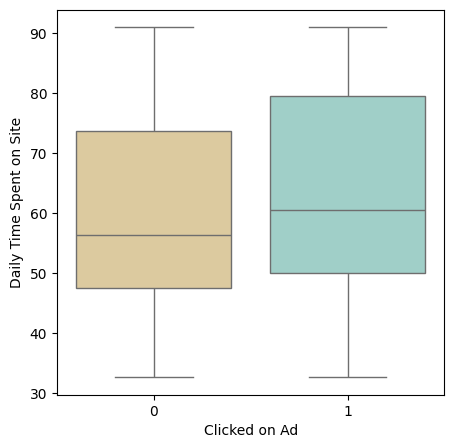

C:\Users\lenovo\AppData\Local\Temp\ipykernel_14904\1127870835.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data["Clicked on Ad"], y=data[i], palette='BrBG')


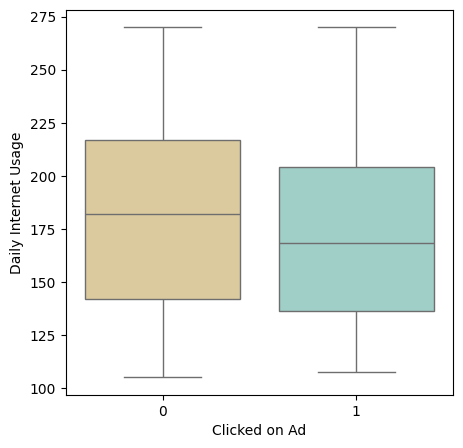

In [24]:
#daily time spent on site
indictor=['Daily Time Spent on Site','Daily Internet Usage']
for i in indictor:
    plt.figure(figsize=(5,5))
    sns.boxplot(x=data["Clicked on Ad"], y=data[i], palette='BrBG')
    plt.show()

#### 2.2 Age distribution

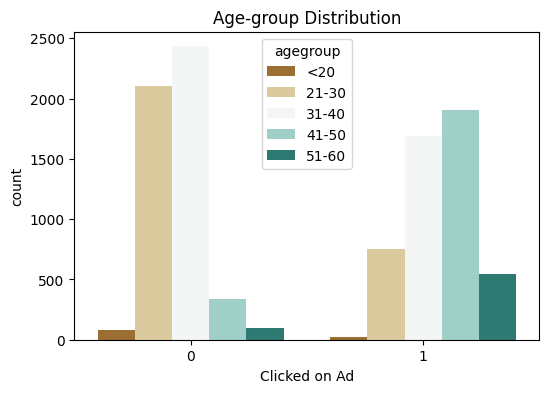

In [25]:
#age
age_bin = ['<20','21-30','31-40','41-50','51-60']
data['agegroup'] = pd.cut(data['Age'], bins=[0,20,30,40,50,60], labels=age_bin)
group_df1 = data.groupby(['Clicked on Ad', 'agegroup'])['id'].count().reset_index()
group_df1
plt.figure(figsize=(6, 4))
sns.barplot(x='Clicked on Ad', y='id', hue='agegroup', data=group_df1, palette='BrBG')
plt.title('Age-group Distribution')
plt.xlabel('Clicked on Ad')
plt.ylabel('count')
plt.legend(title='agegroup')
plt.show()



In [26]:
group_df2

NameError: name 'group_df2' is not defined

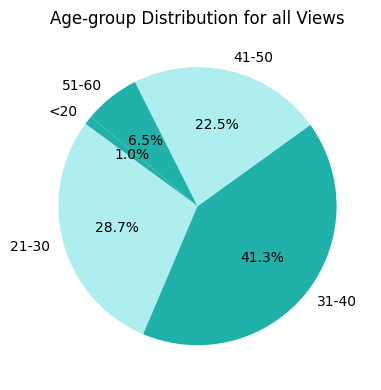

In [ ]:
#age distribution
group_df2=data.groupby('agegroup')['id'].count().reset_index()
plt.figure(figsize=(4, 4))
plt.pie(group_df2['id'], labels=group_df2['agegroup'], autopct='%1.1f%%', colors=colors, startangle=140)
plt.title('Age-group Distribution for all Views')
plt.tight_layout()
plt.show()

#### 2.3 Income distribution

C:\Users\lenovo\AppData\Local\Temp\ipykernel_14904\3515193683.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data["Clicked on Ad"], y=data["Area Income"], palette='BrBG')


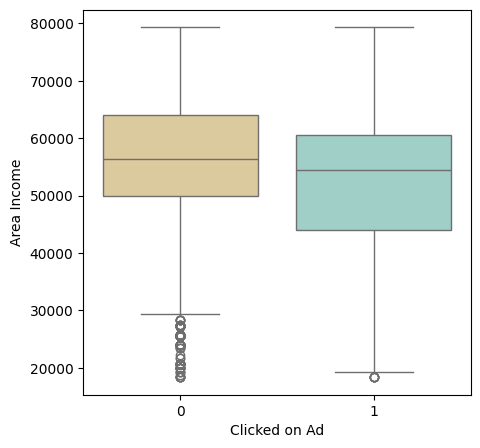

In [27]:
#income
plt.figure(figsize=(5,5))
sns.boxplot(x=data["Clicked on Ad"], y=data["Area Income"], palette='BrBG')
plt.show()

In [28]:
data.shape

(9966, 12)

In [29]:
data['City'].nunique()

521

In [30]:
data['Area Income'].nunique()

521

#### 2.4 Location

In [21]:
#draw the heatmap
df=data[data['Clicked on Ad']==1]
df_draw=df.groupby('Country')['id'].count().sort_values(ascending=False).reset_index()
df_draw=pd.DataFrame(df_draw)
unique_locations = df_draw['Country'].unique()
location_coords = {}

# Using RateLimiter to control request frequency
geolocator = Nominatim(user_agent="geoapiExercises", timeout=10)
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

for location in unique_locations:
    try:
        geo_location = geocode(location)
        if geo_location:
            location_coords[location] = (geo_location.latitude, geo_location.longitude)
    except Exception as e:
        print(f"Error encoding location {location}: {e}")


# Make sure all the coordinates are valid
df_draw['coords'] = df_draw['Country'].apply(lambda x: location_coords.get(x))

# Keep only the rows with valid coordinates
valid_data = df_draw.dropna(subset=['coords'])

# List of latitude, longitude and purchase amounts
heat_data = [[row['coords'][0], row['coords'][1], row['id']] for index, row in valid_data.iterrows()]

# Creating a base map
map = folium.Map(location=[39.8283, -98.5795], zoom_start=4)  # 美国地理中心的坐标

# Adding a Heat Layer
HeatMap(heat_data).add_to(map)

KeyboardInterrupt: 

In [ ]:
map

C:\Users\lenovo\AppData\Local\Temp\ipykernel_15304\2532437771.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_draw.values, y=df_draw.index, palette='BrBG')


<Axes: title={'center': 'Top 10 Countries with highest number of clicks'}, ylabel='Country'>

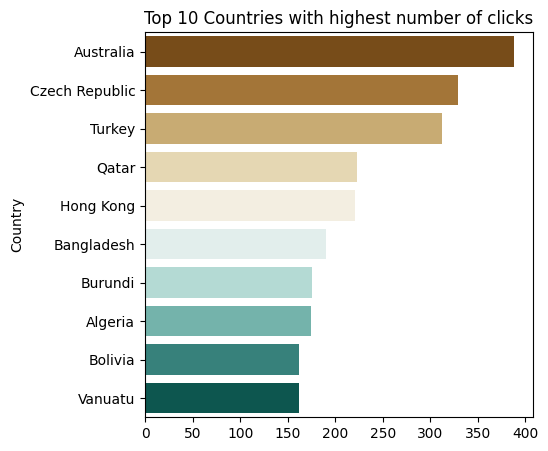

In [ ]:
plt.figure(figsize=(5, 5))
plt.title('Top 10 Countries with highest number of clicks')
df_draw=data.groupby('Country')['id'].count().sort_values(ascending=False).head(10)
sns.barplot(x=df_draw.values, y=df_draw.index, palette='BrBG')

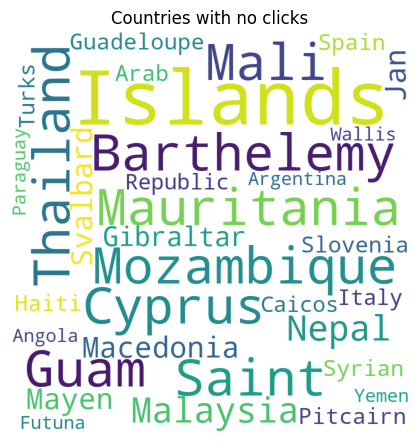

In [ ]:
tail_country=data.groupby('Country')['Clicked on Ad'].sum().sort_values(ascending=True).reset_index()
tail_country=pd.DataFrame(tail_country)
tail_country=tail_country[tail_country['Clicked on Ad']== 0]
text=' '.join(tail_country['Country'].values)
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(text)
plt.figure(figsize=(4, 4), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('Countries with no clicks')
plt.show()

#### 2.5 Gender distribution

In [31]:
colors=['lightseagreen','paleturquoise']

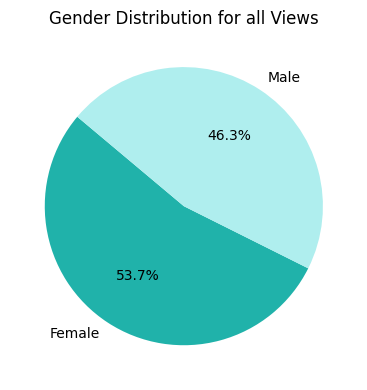

In [32]:
#Gender distribution of views
group_df3=data.groupby('Gender')['id'].count().reset_index()
plt.figure(figsize=(4, 4))
plt.pie(group_df3['id'], labels=['Female','Male'], autopct='%1.1f%%', colors=colors, startangle=140)
plt.title('Gender Distribution for all Views')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Male click distribution')

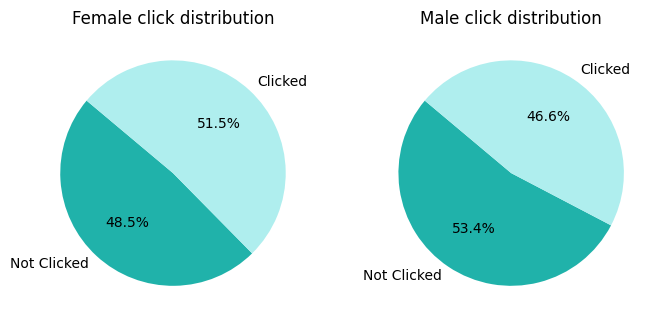

In [33]:
female=data[data['Gender']== 0]
female_click=female.groupby('Clicked on Ad')['id'].count().reset_index()
male=data[data['Gender']== 1]
male_click=male.groupby('Clicked on Ad')['id'].count().reset_index()
fig=plt.figure(figsize=(8,4))
ax1=fig.add_subplot(121)
ax1.pie(female_click['id'], labels=['Not Clicked','Clicked'], autopct='%1.1f%%', colors=colors, startangle=140)
ax1.set_title('Female click distribution')
ax2=fig.add_subplot(122)
ax2.pie(male_click['id'], labels=['Not Clicked','Clicked'], autopct='%1.1f%%', colors=colors, startangle=140)
ax2.set_title('Male click distribution')

#### 2.6 Peak Clicks over time

In [34]:
#define time
data['weekday_name']=data['Timestamp'].dt.day_name()
data['month_name']=data['Timestamp'].dt.month_name()
data['hour']=data['Timestamp'].dt.hour

C:\Users\lenovo\AppData\Local\Temp\ipykernel_14904\2386747607.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data_click[i],palette='BrBG',order=data_click[i].value_counts().index)


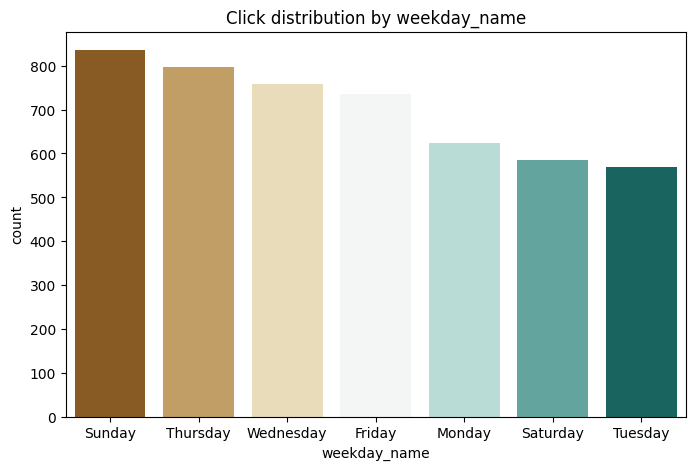

C:\Users\lenovo\AppData\Local\Temp\ipykernel_14904\2386747607.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data_click[i],palette='BrBG',order=data_click[i].value_counts().index)


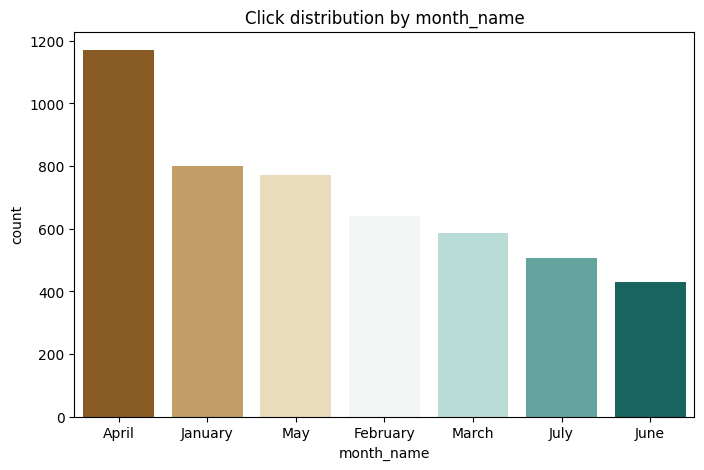

C:\Users\lenovo\AppData\Local\Temp\ipykernel_14904\2386747607.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data_click[i],palette='BrBG',order=data_click[i].value_counts().index)


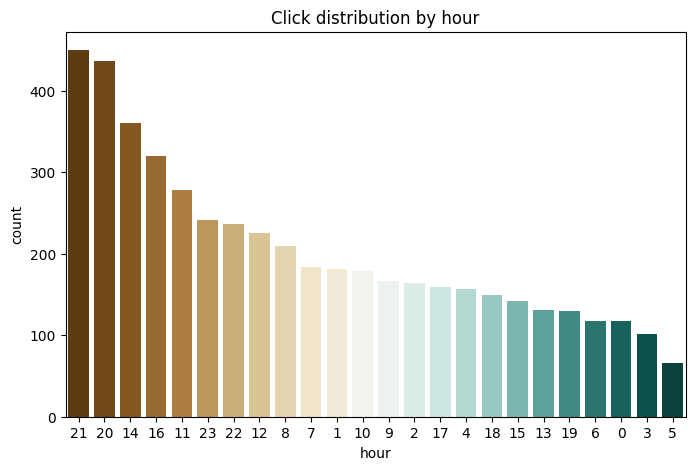

In [35]:
timefreq=['weekday_name','month_name','hour']
data_click=data[data['Clicked on Ad']==1]
for i in timefreq:
    plt.figure(figsize=(8,5))
    sns.countplot(x=data_click[i],palette='BrBG',order=data_click[i].value_counts().index)
    plt.title(f'Click distribution by {i}')
    plt.show()

#### 2.7 Ads Content

C:\Users\lenovo\AppData\Local\Temp\ipykernel_14904\390237808.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_ads.values, y=top_ads.index, palette='BrBG')


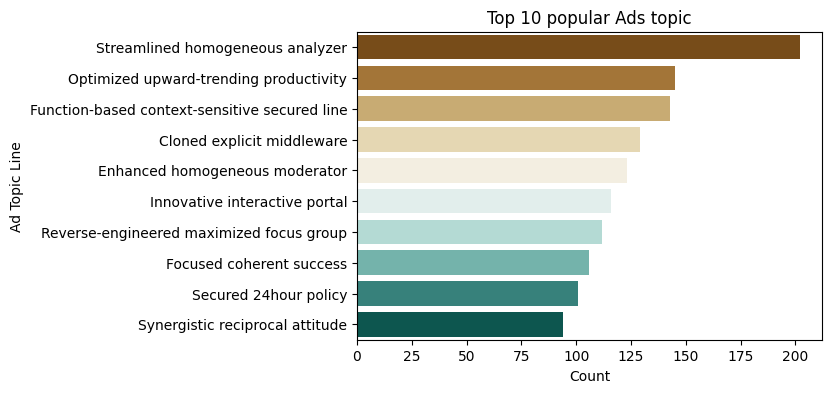

In [36]:
#pupulor Ads topic
df=data[data['Clicked on Ad']==1]
top_ads=df.groupby('Ad Topic Line')['id'].count().sort_values(ascending=False).head(10)
plt.figure(figsize=(6,4))
sns.barplot(x=top_ads.values, y=top_ads.index, palette='BrBG')
plt.xlabel('Count')
plt.title('Top 10 popular Ads topic')
plt.show()


C:\Users\lenovo\AppData\Local\Temp\ipykernel_14904\3646822526.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=no_clicks_views['Total Views'], y=no_clicks_views['Ad Topic Line'], palette='BrBG')


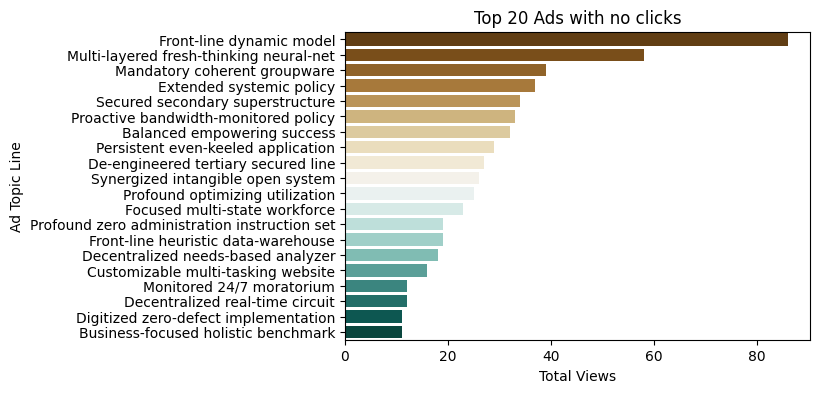

In [37]:
#ads's total views with no clicks
total_clicks = data.groupby('Ad Topic Line')['Clicked on Ad'].sum().sort_values(ascending=False)
no_clicks = total_clicks[total_clicks == 0]
total_views = data.groupby('Ad Topic Line')['id'].count()
no_clicks_views = total_views[no_clicks.index]
no_clicks_views = no_clicks_views.sort_values(ascending=False)
no_clicks_views=pd.DataFrame(no_clicks_views).head(20).reset_index()
no_clicks_views.rename(columns={'id':'Total Views'},inplace=True)
plt.figure(figsize=(6,4))
sns.barplot(x=no_clicks_views['Total Views'], y=no_clicks_views['Ad Topic Line'], palette='BrBG')
plt.xlabel('Total Views')
plt.title('Top 20 Ads with no clicks')
plt.show()

### 3. Prediction model

#### 3.0 data pre-process

##### drop useless column

In [98]:
df1=data.drop(columns=['id', 'agegroup', 'weekday_name', 'month_name'])

##### encode

In [99]:
#pre-processing of data for regression
df1['weekday'] = df1['Timestamp'].dt.dayofweek
df1['month'] = df1['Timestamp'].dt.month
#le code
le_city = LabelEncoder()
le_country = LabelEncoder()
le_adtopic = LabelEncoder()
df1['City'] = le_city.fit_transform(df1['City'])
df1['Country'] = le_country.fit_transform(df1['Country'])
df1.drop(columns=['Timestamp'], axis=1, inplace=True)
df1['Ad Topic Line'] = le_adtopic.fit_transform(df1['Ad Topic Line'])

In [100]:
df1['Ad Topic Line'].nunique()

558

In [42]:
# #prepare for regression
# # build TF-IDF model
# tfidf_vectorizer = TfidfVectorizer()
# tfidf = tfidf_vectorizer.fit_transform(df1['Ad Topic Line'])

# tfidf_df = pd.DataFrame(tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# # reset_index
# df1_reset = df1.reset_index(drop=True)
# tfidf_df_reset = tfidf_df.reset_index(drop=True)

# # concat two data frames
# df2 = pd.concat([df1_reset, tfidf_df_reset], axis=1)

# df2.drop(columns=['Ad Topic Line'], axis=1, inplace=True)

##### check null value

In [102]:
df1.isnull().any().sum()

0

##### check data balance

In [103]:
### data balance test
df1['Clicked on Ad'].value_counts()

Clicked on Ad
0    5061
1    4905
Name: count, dtype: int64

##### standardize data

In [104]:
df1.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Gender,Country,Clicked on Ad,hour,weekday,month
0,62.26,32.0,69481.85,172.83,96,234,1,173,0,21,3,6
1,41.73,31.0,61840.26,207.17,301,460,1,165,0,17,5,1
2,44.40,30.0,57877.15,172.83,484,379,0,71,0,10,2,6
3,59.88,28.0,56180.93,207.17,24,269,0,204,0,14,1,6
4,49.21,30.0,54324.73,201.58,484,495,0,148,1,10,3,7


In [105]:
scaler=StandardScaler()
scaler_var=['Daily Time Spent on Site','Area Income','Daily Internet Usage','Ad Topic Line','City','Country']
for i in scaler_var:
    df1[i]=scaler.fit_transform(df1[[i]])

In [106]:
# save the scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [135]:
df1['Age']=df1['Age'].astype('int')

In [137]:
df1.to_csv('df1.csv',index=False)

In [109]:
# Save the label encoders
label_encoders = {
    'City': le_city,
    'Country': le_country,
    'Gender': le_gender,
    'Clicked on Ad': le_click,
    'Ad Topic Line': le_adtopic
}

with open('label_encoders.pkl', 'wb') as le_file:
    pickle.dump(label_encoders, le_file)

#### 3.1 Logit model

In [139]:
df1=pd.read_csv('df1.csv')

Optimization terminated successfully.
         Current function value: 0.558066
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:          Clicked on Ad   No. Observations:                 6976
Model:                          Logit   Df Residuals:                     6965
Method:                           MLE   Df Model:                           10
Date:                Mon, 01 Jul 2024   Pseudo R-squ.:                  0.1946
Time:                        21:36:05   Log-Likelihood:                -3893.1
converged:                       True   LL-Null:                       -4833.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -4.6243      0.164    -28.169      0.000      -4.946

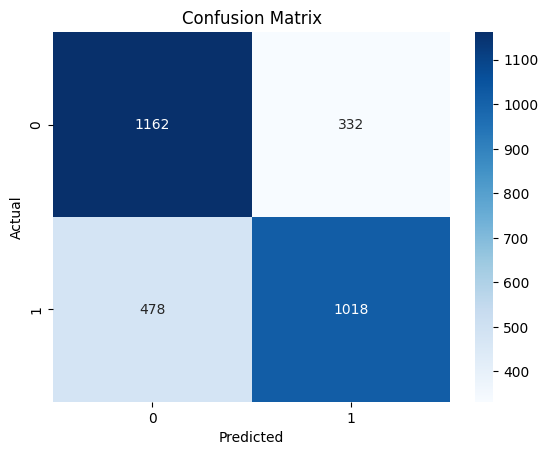

AUC: 0.7880908661383503


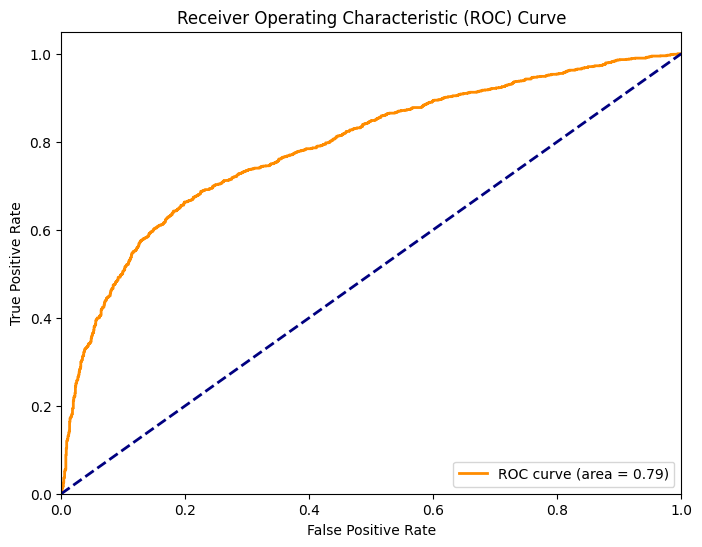

F1 Score: 0.7153900210822206


In [142]:
X = df1.drop('Clicked on Ad', axis=1)
y = df1['Clicked on Ad']
# add constant
X = sm.add_constant(X)
xx=df1.drop('Clicked on Ad', axis=1)
# split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#statsmodels logistic regression
logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()


print(result.summary())
print(xx.columns)

# predict
prob_predictions = result.predict(X_test)

# convert probabilities to binary(use 0.5 as threshold)
y_pred = (prob_predictions > 0.5).astype(int)

# classification report
accuracy_logit = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy_logit}")

# confusion matrix
conf_matrix_logit = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix_logit, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC AUC
#fpr:false positive rate, tpr:true positive rate
fpr, tpr, thresholds = roc_curve(y_test, prob_predictions)
auc_logit = auc(fpr, tpr)

# print AUC
print(f"AUC: {auc_logit}")

# draw ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_logit:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
#restrict x and y
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#f1-score
f1_logit = f1_score(y_test, y_pred)
print(f"F1 Score: {f1_logit}")


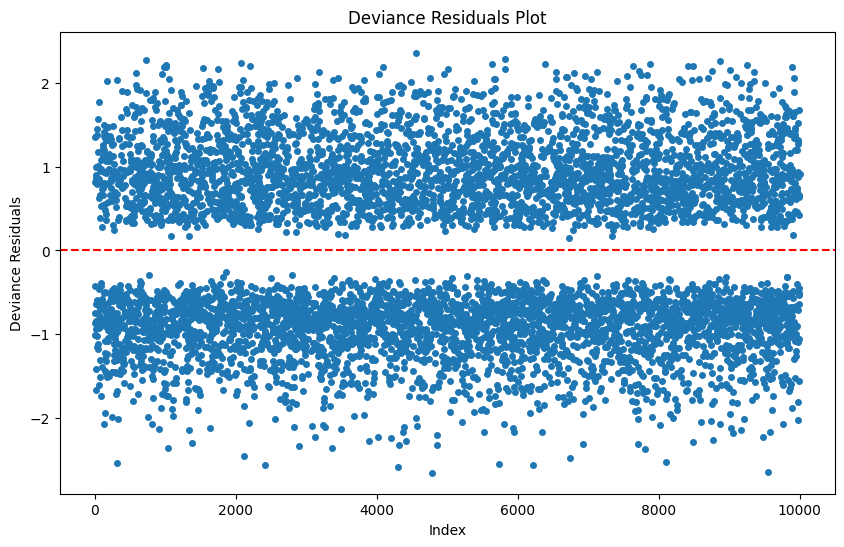

In [ ]:
# 计算残差
residuals = result.resid_dev

# 绘制残差图
plt.figure(figsize=(10, 6))
plt.plot(residuals, 'o', markersize=4)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Deviance Residuals')
plt.title('Deviance Residuals Plot')
plt.show()

#### 3.2 Decision tree

In [143]:
X = df1.drop('Clicked on Ad', axis=1)
y = df1['Clicked on Ad']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [144]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9966 entries, 0 to 9965
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  9966 non-null   float64
 1   Age                       9966 non-null   int64  
 2   Area Income               9966 non-null   float64
 3   Daily Internet Usage      9966 non-null   float64
 4   Ad Topic Line             9966 non-null   float64
 5   Gender                    9966 non-null   int64  
 6   Country                   9966 non-null   float64
 7   hour                      9966 non-null   int64  
 8   weekday                   9966 non-null   int64  
 9   month                     9966 non-null   int64  
dtypes: float64(5), int64(5)
memory usage: 778.7 KB


Accuracy Score: 0.7735785953177258


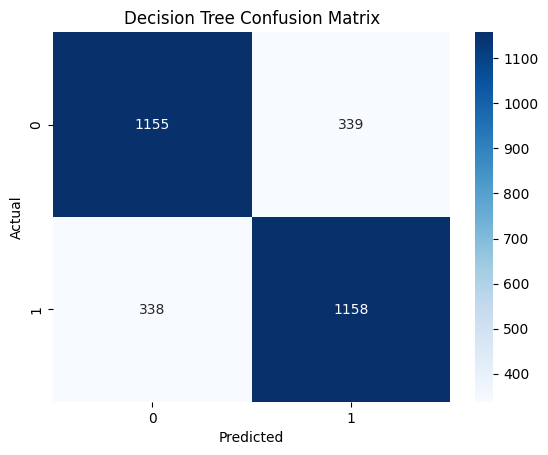

AUC: 0.7735782703004532


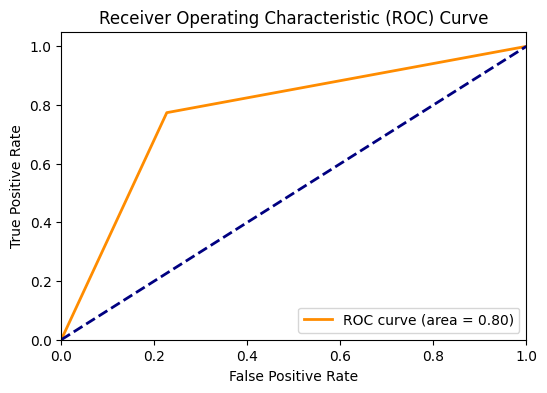

F1 Score: 0.7738055462746408


In [145]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

#accuracy rate
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Accuracy Score: {accuracy_dt}")
# confusion matrix
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(conf_matrix_dt, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Decision Tree Confusion Matrix')
plt.show()

# ROC AUC
#fpr:false positive rate, tpr:true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_pred_dt)
auc_dt = auc(fpr, tpr)

# print AUC
print(f"AUC: {auc_dt}")

# draw ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#f1-score
f1_dt = f1_score(y_test, y_pred_dt)
print(f"F1 Score: {f1_dt}")

C:\Users\lenovo\AppData\Local\Temp\ipykernel_14904\503830464.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='BrBG')


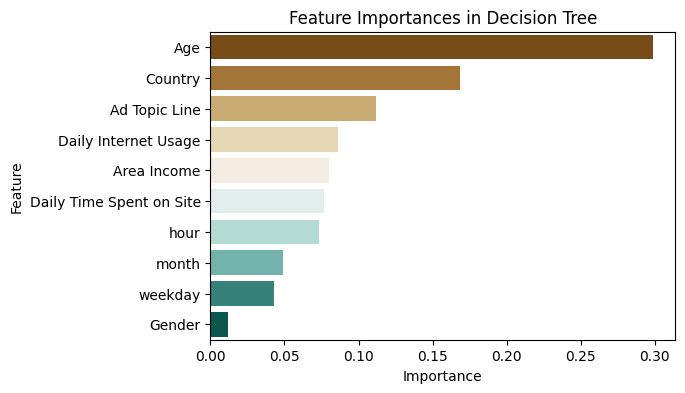

In [146]:
# feature importances
feature_importances = dt_model.feature_importances_

# create a dataframe to store feature importances
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# order by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

plt.figure(figsize=(6, 4))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='BrBG')
plt.title('Feature Importances in Decision Tree')
plt.show()

#### 3.3 KNN

KNN Accuracy: 0.8036789297658863


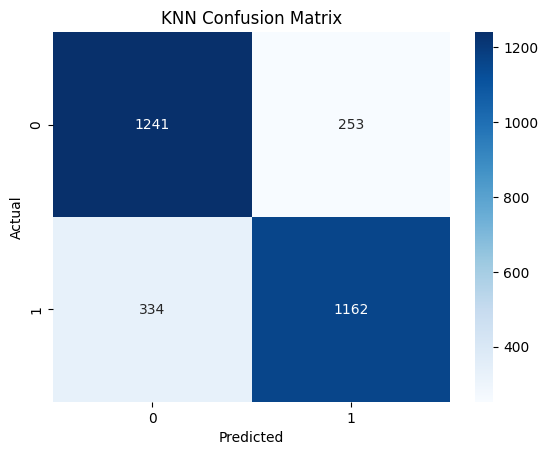

AUC: 0.8036969625382099


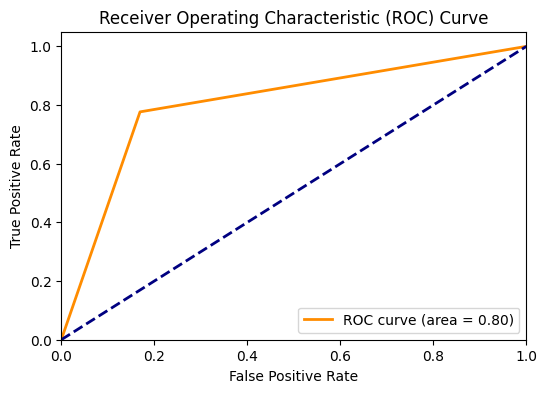

F1 Score: 0.7983510821023703


In [147]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

y_pred_knn = knn_model.predict(X_test)

accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"KNN Accuracy: {accuracy_knn}")

conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('KNN Confusion Matrix')
plt.show()

# ROC AUC
#fpr:false positive rate, tpr:true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_pred_knn)
auc_knn = auc(fpr, tpr)

# print AUC
print(f"AUC: {auc_knn}")

# draw ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#f1-score
f1_knn = f1_score(y_test, y_pred_knn)
print(f"F1 Score: {f1_knn}")

#### 3.4 SVM

SVM Accuracy: 0.7244147157190636


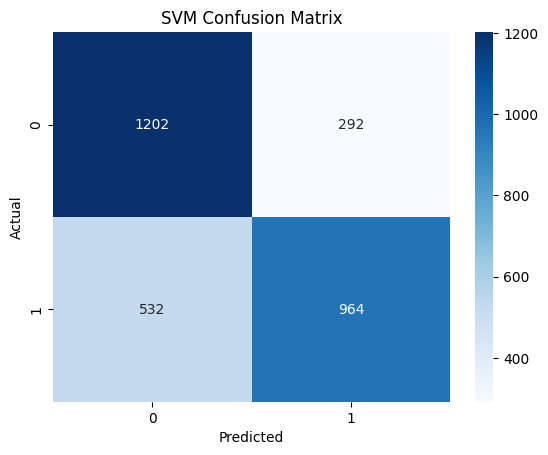

AUC: 0.7244682831146333


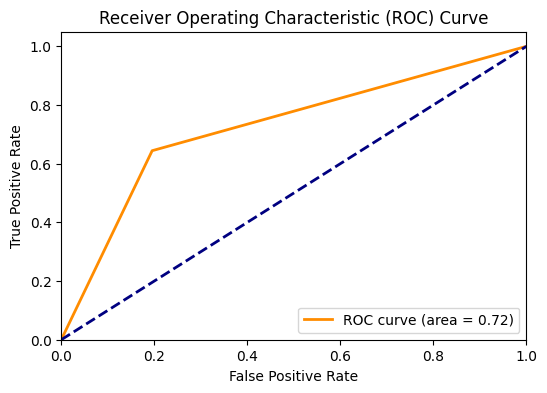

F1 Score: 0.7005813953488372


In [148]:
svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {accuracy_svm}")

conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('SVM Confusion Matrix')
plt.show()

# ROC AUC
#fpr:false positive rate, tpr:true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_pred_svm)
auc_svm = auc(fpr, tpr)

# print AUC
print(f"AUC: {auc_svm}")

# draw ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_svm:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#f1-score
f1_svm = f1_score(y_test, y_pred_svm)
print(f"F1 Score: {f1_svm}")

#### 3.5 Random forest

Random Forest Accuracy: 0.8264214046822742


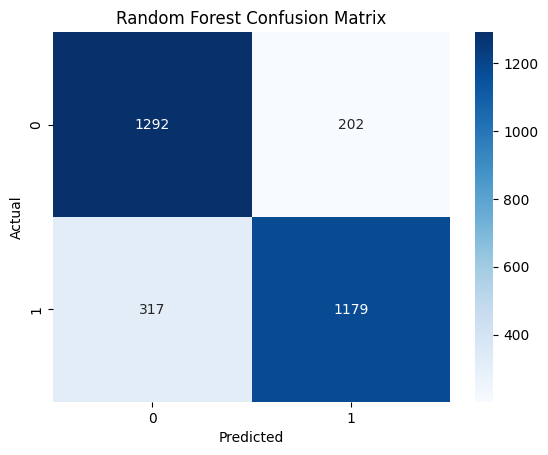

AUC: 0.8264470538123975


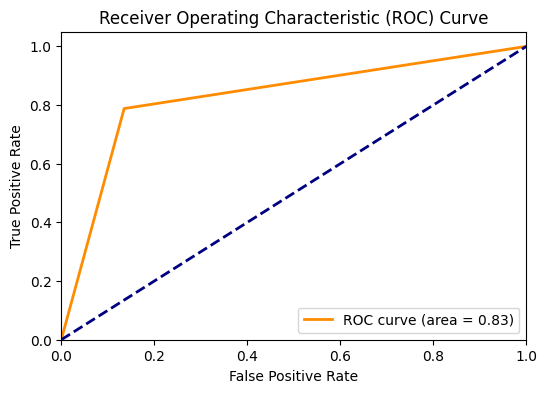

F1 Score: 0.8196037539103233


In [149]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf}")

conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()

# ROC AUC
#fpr:false positive rate, tpr:true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rf)
auc_rf = auc(fpr, tpr)

# print AUC
print(f"AUC: {auc_rf}")

# draw ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#f1-score
f1_rf = f1_score(y_test, y_pred_rf)
print(f"F1 Score: {f1_rf}")


#### 3.6 XG Boost

XGBoost Accuracy: 0.8508361204013378


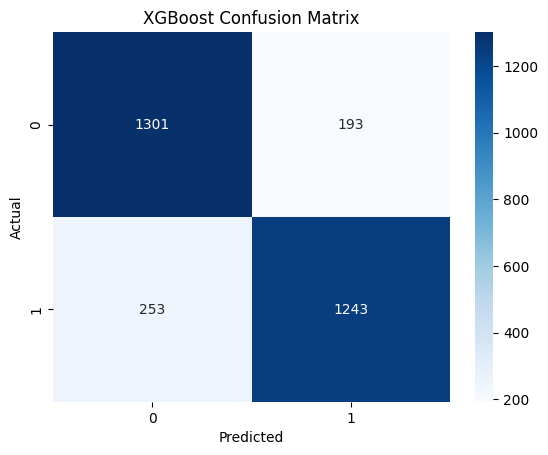

AUC: 0.8508494763367195


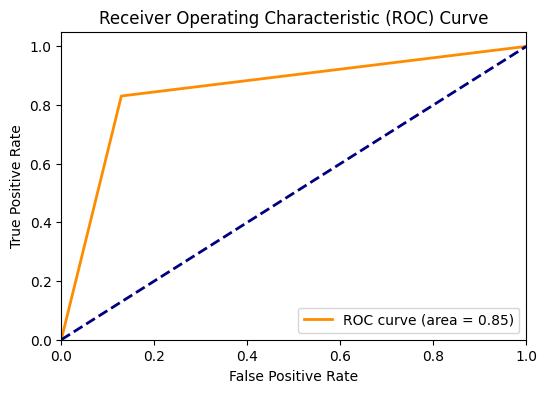

F1 Score: 0.8478854024556617


In [163]:
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)
    
y_pred_xgb = xgb_model.predict(X_test)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {accuracy_xgb}")

conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost Confusion Matrix')
plt.show()

# ROC AUC
#fpr:false positive rate, tpr:true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_pred_xgb)
auc_xgb = auc(fpr, tpr)

# print AUC
print(f"AUC: {auc_xgb}")

# draw ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#f1-score
f1_xgb = f1_score(y_test, y_pred_xgb)
print(f"F1 Score: {f1_xgb}")


#### 3.7 GBM

Accuracy: 0.8003344481605351
F1 Score: 0.7897146882705178
AUC: 0.8003685866460496


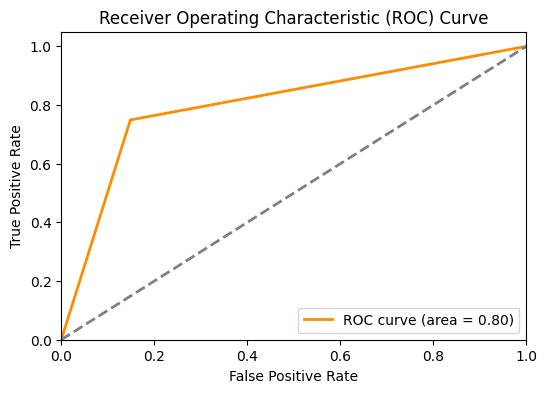

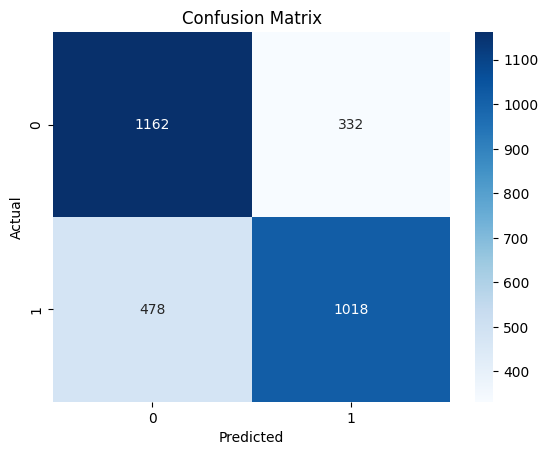

In [151]:
# train GBM model
gbm = GradientBoostingClassifier()
gbm.fit(X_train, y_train)

# prediction
y_pred_gbm = gbm.predict(X_test)

# evaluate model
accuracy_gbm = accuracy_score(y_test, y_pred_gbm)
f1_gbm = f1_score(y_test, y_pred_gbm)

print(f"Accuracy: {accuracy_gbm}")
print(f"F1 Score: {f1_gbm}")

# ROC AUC
#fpr:false positive rate, tpr:true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_pred_gbm)
auc_gbm = auc(fpr, tpr)

# print AUC
print(f"AUC: {auc_gbm}")

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_gbm:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### 4. Final Summary

C:\Users\lenovo\AppData\Local\Temp\ipykernel_14904\1306456163.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='accuracy', data=df, palette='BrBG')


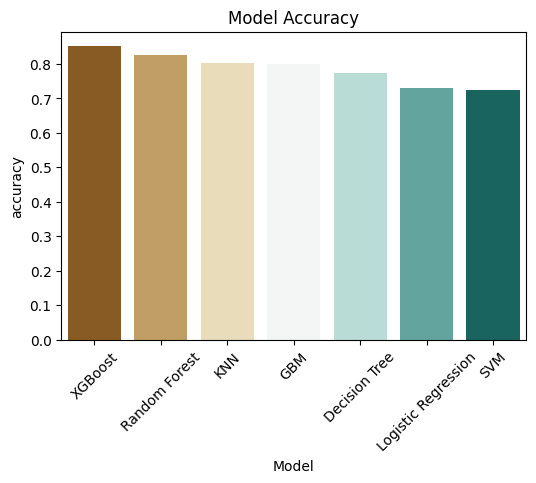

In [164]:
accuracy=[accuracy_logit,accuracy_dt,accuracy_knn,accuracy_svm,accuracy_rf,accuracy_xgb, accuracy_gbm]
model=['Logistic Regression','Decision Tree','KNN','SVM','Random Forest','XGBoost','GBM']

# Create a DataFrame
df = pd.DataFrame({'Model': model, 'accuracy': accuracy})

# Sort DataFrame by AUC in descending order
df = df.sort_values(by='accuracy', ascending=False)

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(x='Model', y='accuracy', data=df, palette='BrBG')
plt.title('Model Accuracy')
plt.xticks(rotation=45)
plt.show()


C:\Users\lenovo\AppData\Local\Temp\ipykernel_14904\203141361.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='AUC', data=df, palette='BrBG')


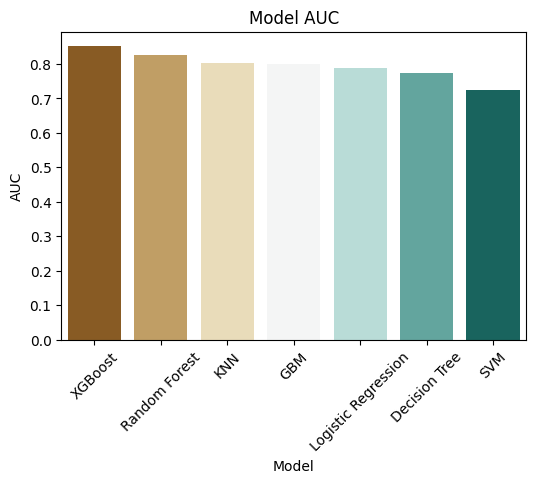

In [165]:
#AUC
auc=[auc_logit,auc_dt,auc_knn,auc_svm,auc_rf,auc_xgb,auc_gbm]
model=['Logistic Regression','Decision Tree','KNN','SVM','Random Forest','XGBoost','GBM']

# Create a DataFrame
df = pd.DataFrame({'Model': model, 'AUC': auc})

# Sort DataFrame by AUC in descending order
df = df.sort_values(by='AUC', ascending=False)

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(x='Model', y='AUC', data=df, palette='BrBG')
plt.title('Model AUC')
plt.xticks(rotation=45)
plt.show()

C:\Users\lenovo\AppData\Local\Temp\ipykernel_14904\3460219232.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='F1-score', data=df, palette='BrBG')


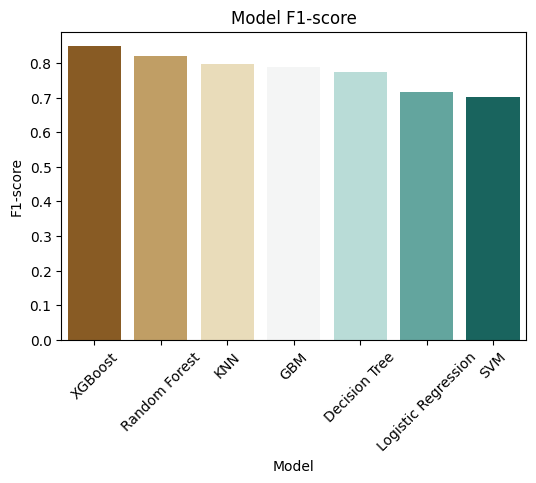

In [166]:
#F1-score
f1_score=[f1_logit,f1_dt,f1_knn,f1_svm,f1_rf,f1_xgb,f1_gbm]
model=['Logistic Regression','Decision Tree','KNN','SVM','Random Forest','XGBoost','GBM']

# Create a DataFrame
df = pd.DataFrame({'Model': model, 'F1-score': f1_score})

# Sort DataFrame by F1-score in descending order
df = df.sort_values(by='F1-score', ascending=False)

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(x='Model', y='F1-score', data=df, palette='BrBG')
plt.title('Model F1-score')
plt.xticks(rotation=45)
plt.show()

we finally select XG Boost model as our prediction model

### SAVE MODEL TO A FILE

In [155]:
import pickle

In [156]:
# Save the trained model to a file
with open('xgb_model.pkl', 'wb') as model_file:
    pickle.dump(xgb_model, model_file)

In [157]:
data.to_csv('data_before_code.csv',index=False)

In [158]:
df1

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,Gender,Country,Clicked on Ad,hour,weekday,month
0,0.037976,32,1.177804,-0.120532,-1.078997,1,1.212300,0,21,3,6
1,-1.269118,31,0.597431,0.720683,0.179104,1,1.088142,0,17,5,1
2,-1.099126,30,0.296437,-0.120532,1.302189,0,-0.370718,0,10,2,6
3,-0.113552,28,0.167610,0.720683,-1.520867,0,1.693414,0,14,1,6
4,-0.792885,30,0.026633,0.583747,1.302189,0,0.824306,1,10,3,7
...,...,...,...,...,...,...,...,...,...,...,...
9961,-1.269118,31,0.597431,0.720683,0.498232,1,1.088142,1,3,6,1
9962,-1.269118,28,-0.187798,-1.402687,-0.189121,1,0.156955,0,12,5,5
9963,-0.386049,39,-1.208121,-1.305925,-0.305725,0,-0.727674,0,11,1,1
9964,-0.958421,50,-0.759459,-1.338016,0.762127,0,0.203514,1,7,0,4


In [159]:
data

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Gender,Country,Timestamp,Clicked on Ad,id,agegroup,weekday_name,month_name,hour
0,62.26,32.0,69481.85,172.83,Decentralized real-time circuit,Lisafort,1,Svalbard & Jan Mayen Islands,2016-06-09 21:43:05,0,0,31-40,Thursday,June,21
1,41.73,31.0,61840.26,207.17,Optional full-range projection,West Angelabury,1,Singapore,2016-01-16 17:56:05,0,1,31-40,Saturday,January,17
2,44.40,30.0,57877.15,172.83,Total 5thgeneration standardization,Reyesfurt,0,Guadeloupe,2016-06-29 10:50:45,0,2,21-30,Wednesday,June,10
3,59.88,28.0,56180.93,207.17,Balanced empowering success,New Michael,0,Zambia,2016-06-21 14:32:32,0,3,21-30,Tuesday,June,14
4,49.21,30.0,54324.73,201.58,Total 5thgeneration standardization,West Richard,0,Qatar,2016-07-21 10:54:35,1,4,21-30,Thursday,July,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,41.73,31.0,61840.26,207.17,Profound executive flexibility,West Angelabury,1,Singapore,2016-01-03 03:22:15,1,9995,31-40,Sunday,January,3
9996,41.73,28.0,51501.38,120.49,Managed zero tolerance concept,Kennedyfurt,1,Luxembourg,2016-05-28 12:20:15,0,9996,21-30,Saturday,May,12
9997,55.60,39.0,38067.08,124.44,Intuitive exuding service-desk,North Randy,0,Egypt,2016-01-05 11:53:17,0,9997,31-40,Tuesday,January,11
9998,46.61,50.0,43974.49,123.13,Realigned content-based leverage,North Samantha,0,Malawi,2016-04-04 07:07:46,1,9998,41-50,Monday,April,7
